## Token filtering
the training is taking too long. we will filter for length

In [1]:
from datasets import load_dataset

math = load_dataset("open-r1/OpenR1-Math-220k", "extended")["train"]

/home/user/repos/MoveFast/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoTokenizer

model_id = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.chat_template = "{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- set date_string = \"26 Jul 2024\" %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0]['role'] == 'system' %}\n    {%- set system_message = messages[0]['content']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = \"You are a helpful AI Assistant that provides well-reasoned and detailed responses. You first think about the reasoning process as an internal monologue and then provide the user with the answer. Respond in the following format: <think>\n...\n</think>\n<answer>\n...\n</answer>\" %}\n{%- endif %}\n\n{#- System message + builtin tools #}\n{{- \"<|start_header_id|>system<|end_header_id|>\\n\\n\" }}\n{%- if builtin_tools is defined or tools is not none %}\n    {{- \"Environment: ipython\\n\" }}\n{%- endif %}\n{%- if builtin_tools is defined %}\n    {{- \"Tools: \" + builtin_tools | reject('equalto', 'code_interpreter') | join(\", \") + \"\\n\\n\"}}\n{%- endif %}\n{{- \"Cutting Knowledge Date: December 2023\\n\" }}\n{{- \"Today Date: \" + date_string + \"\\n\\n\" }}\n{%- if tools is not none and not tools_in_user_message %}\n    {{- \"You have access to the following functions. To call a function, please respond with JSON for a function call.\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n{%- endif %}\n{{- system_message }}\n{{- \"<|eot_id|>\" }}\n\n{#- Custom tools are passed in a user message with some extra guidance #}\n{%- if tools_in_user_message and not tools is none %}\n    {#- Extract the first user message so we can plug it in here #}\n    {%- if messages | length != 0 %}\n        {%- set first_user_message = messages[0]['content']|trim %}\n        {%- set messages = messages[1:] %}\n    {%- else %}\n        {{- raise_exception(\"Cannot put tools in the first user message when there's no first user message!\") }}\n{%- endif %}\n    {{- '<|start_header_id|>user<|end_header_id|>\\n\\n' -}}\n    {{- \"Given the following functions, please respond with a JSON for a function call \" }}\n    {{- \"with its proper arguments that best answers the given prompt.\\n\\n\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n    {{- first_user_message + \"<|eot_id|>\"}}\n{%- endif %}\n\n{%- for message in messages %}\n    {%- if not (message.role == 'ipython' or message.role == 'tool' or 'tool_calls' in message) %}\n        {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\\n\\n'+ message['content'] | trim + '<|eot_id|>' }}\n    {%- elif 'tool_calls' in message %}\n        {%- if not message.tool_calls|length == 1 %}\n            {{- raise_exception(\"This model only supports single tool-calls at once!\") }}\n        {%- endif %}\n        {%- set tool_call = message.tool_calls[0].function %}\n        {%- if builtin_tools is defined and tool_call.name in builtin_tools %}\n            {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' -}}\n            {{- \"<|python_tag|>\" + tool_call.name + \".call(\" }}\n            {%- for arg_name, arg_val in tool_call.arguments | items %}\n                {{- arg_name + '=\"' + arg_val + '\"' }}\n                {%- if not loop.last %}\n                    {{- \", \" }}\n                {%- endif %}\n                {%- endfor %}\n            {{- \")\" }}\n        {%- else  %}\n            {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' -}}\n            {{- '{\"name\": \"' + tool_call.name + '\", ' }}\n            {{- '\"parameters\": ' }}\n            {{- tool_call.arguments | tojson }}\n            {{- \"}\" }}\n        {%- endif %}\n        {%- if builtin_tools is defined %}\n            {#- This means we're in ipython mode #}\n            {{- \"<|eom_id|>\" }}\n        {%- else %}\n            {{- \"<|eot_id|>\" }}\n        {%- endif %}\n    {%- elif message.role == \"tool\" or message.role == \"ipython\" %}\n        {{- \"<|start_header_id|>ipython<|end_header_id|>\\n\\n\" }}\n        {%- if message.content is mapping or message.content is iterable %}\n            {{- message.content | tojson }}\n        {%- else %}\n            {{- message.content }}\n        {%- endif %}\n        {{- \"<|eot_id|>\" }}\n    {%- endif %}\n{%- endfor %}\n{%- if add_generation_prompt %}\n    {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' }}\n{%- endif %}\n"
  

messages = [
    {"role": "user", "content": "hello"},
    {"role": "assistant", "content": "yo"}
]

print(tokenizer.apply_chat_template(messages, tokenize=False))

/home/user/repos/MoveFast/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a helpful AI Assistant that provides well-reasoned and detailed responses. You first think about the reasoning process as an internal monologue and then provide the user with the answer. Respond in the following format: <think>
...
</think>
<answer>
...
</answer><|eot_id|><|start_header_id|>user<|end_header_id|>

hello<|eot_id|><|start_header_id|>assistant<|end_header_id|>

yo<|eot_id|>


In [6]:
len(tokenizer.apply_chat_template(math[0]['messages'], tokenize=True))

2156

In [17]:
print(len(math))

131396


In [25]:
from datasets import load_dataset

math = load_dataset("open-r1/OpenR1-Math-220k", "extended")["train"]

from transformers import AutoTokenizer

model_id = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.chat_template = "{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- set date_string = \"26 Jul 2024\" %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0]['role'] == 'system' %}\n    {%- set system_message = messages[0]['content']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = \"You are a helpful AI Assistant that provides well-reasoned and detailed responses. You first think about the reasoning process as an internal monologue and then provide the user with the answer. Respond in the following format: <think>\n...\n</think>\n<answer>\n...\n</answer>\" %}\n{%- endif %}\n\n{#- System message + builtin tools #}\n{{- \"<|start_header_id|>system<|end_header_id|>\\n\\n\" }}\n{%- if builtin_tools is defined or tools is not none %}\n    {{- \"Environment: ipython\\n\" }}\n{%- endif %}\n{%- if builtin_tools is defined %}\n    {{- \"Tools: \" + builtin_tools | reject('equalto', 'code_interpreter') | join(\", \") + \"\\n\\n\"}}\n{%- endif %}\n{{- \"Cutting Knowledge Date: December 2023\\n\" }}\n{{- \"Today Date: \" + date_string + \"\\n\\n\" }}\n{%- if tools is not none and not tools_in_user_message %}\n    {{- \"You have access to the following functions. To call a function, please respond with JSON for a function call.\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n{%- endif %}\n{{- system_message }}\n{{- \"<|eot_id|>\" }}\n\n{#- Custom tools are passed in a user message with some extra guidance #}\n{%- if tools_in_user_message and not tools is none %}\n    {#- Extract the first user message so we can plug it in here #}\n    {%- if messages | length != 0 %}\n        {%- set first_user_message = messages[0]['content']|trim %}\n        {%- set messages = messages[1:] %}\n    {%- else %}\n        {{- raise_exception(\"Cannot put tools in the first user message when there's no first user message!\") }}\n{%- endif %}\n    {{- '<|start_header_id|>user<|end_header_id|>\\n\\n' -}}\n    {{- \"Given the following functions, please respond with a JSON for a function call \" }}\n    {{- \"with its proper arguments that best answers the given prompt.\\n\\n\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n    {{- first_user_message + \"<|eot_id|>\"}}\n{%- endif %}\n\n{%- for message in messages %}\n    {%- if not (message.role == 'ipython' or message.role == 'tool' or 'tool_calls' in message) %}\n        {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\\n\\n'+ message['content'] | trim + '<|eot_id|>' }}\n    {%- elif 'tool_calls' in message %}\n        {%- if not message.tool_calls|length == 1 %}\n            {{- raise_exception(\"This model only supports single tool-calls at once!\") }}\n        {%- endif %}\n        {%- set tool_call = message.tool_calls[0].function %}\n        {%- if builtin_tools is defined and tool_call.name in builtin_tools %}\n            {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' -}}\n            {{- \"<|python_tag|>\" + tool_call.name + \".call(\" }}\n            {%- for arg_name, arg_val in tool_call.arguments | items %}\n                {{- arg_name + '=\"' + arg_val + '\"' }}\n                {%- if not loop.last %}\n                    {{- \", \" }}\n                {%- endif %}\n                {%- endfor %}\n            {{- \")\" }}\n        {%- else  %}\n            {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' -}}\n            {{- '{\"name\": \"' + tool_call.name + '\", ' }}\n            {{- '\"parameters\": ' }}\n            {{- tool_call.arguments | tojson }}\n            {{- \"}\" }}\n        {%- endif %}\n        {%- if builtin_tools is defined %}\n            {#- This means we're in ipython mode #}\n            {{- \"<|eom_id|>\" }}\n        {%- else %}\n            {{- \"<|eot_id|>\" }}\n        {%- endif %}\n    {%- elif message.role == \"tool\" or message.role == \"ipython\" %}\n        {{- \"<|start_header_id|>ipython<|end_header_id|>\\n\\n\" }}\n        {%- if message.content is mapping or message.content is iterable %}\n            {{- message.content | tojson }}\n        {%- else %}\n            {{- message.content }}\n        {%- endif %}\n        {{- \"<|eot_id|>\" }}\n    {%- endif %}\n{%- endfor %}\n{%- if add_generation_prompt %}\n    {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' }}\n{%- endif %}\n"
  


lengths = []
from tqdm import tqdm
for i in tqdm(range(100)):
    messages = math[i]['messages']
    tokenized = tokenizer.apply_chat_template(messages, tokenize=True)
    length = len(tokenized)
    lengths.append(length)
print(lengths)
print(sum(lengths) / len(lengths))

100%|██████████| 100/100 [00:00<00:00, 201.70it/s]

[2156, 2531, 2874, 1625, 4343, 5269, 2876, 4658, 2852, 2186, 2739, 3528, 1305, 1364, 9189, 6043, 3608, 2320, 1556, 5095, 1892, 2117, 2419, 4732, 4936, 437, 1207, 2708, 6569, 3113, 2435, 6295, 3825, 4680, 3093, 1715, 4712, 7887, 5872, 5390, 1996, 1840, 1840, 897, 12010, 1581, 14362, 1322, 1719, 1542, 4784, 1320, 2646, 3633, 1238, 2541, 2551, 14486, 4483, 2250, 1358, 3680, 4189, 5292, 1506, 6465, 2893, 1847, 7100, 3029, 11633, 3472, 6071, 1161, 4456, 3622, 4364, 2777, 4879, 6798, 2563, 8203, 1049, 1213, 2195, 4200, 3256, 1808, 4115, 2352, 2990, 10417, 5032, 3386, 3675, 3159, 1316, 927, 4073, 5152]
3808.65


In [27]:
# check tokenized length
n = 4096
def filter_long_rows(example):
    messages = example['messages']
    tokenized = tokenizer.apply_chat_template(messages, tokenize=True)
    length = len(tokenized)
    return length <= 4096

In [44]:
first = math[8]
# print(first['messages'])
print(tokenizer.apply_chat_template(first['messages'], tokenize=False))
print(len(tokenizer.apply_chat_template(first['messages'], tokenize=True)))
filter_long_rows(first)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a helpful AI Assistant that provides well-reasoned and detailed responses. You first think about the reasoning process as an internal monologue and then provide the user with the answer. Respond in the following format: <think>
...
</think>
<answer>
...
</answer><|eot_id|><|start_header_id|>user<|end_header_id|>

Given the function $f(x)=x^{3}+ \log ( \sqrt {x^{2}+1}+x)$, if $a$ and $b$ in the domain of $f(x)$ satisfy $f(-a)+f(-b)-3=f(a)+f(b)+3$, find the value of $f(a)+f(b)$.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

<think>
Alright, let's tackle this problem step by step. The function given is \( f(x) = x^3 + \log\left( \sqrt{x^2 + 1} + x \right) \). We need to find the value of \( f(a) + f(b) \) given that \( a \) and \( b \) satisfy the equation \( f(-a) + f(-b) - 3 = f(a) + f(b) + 3 \).

First, let me understand the function \( f(x) \). 

True

In [46]:
math_filtered = math.filter(filter_long_rows, num_proc=16)

Filter (num_proc=16): 100%|██████████| 131396/131396 [00:45<00:00, 2878.42 examples/s]


In [47]:
print(math_filtered)

Dataset({
    features: ['problem', 'solution', 'answer', 'problem_type', 'question_type', 'source', 'uuid', 'is_reasoning_complete', 'generations', 'correctness_math_verify', 'correctness_llama', 'finish_reasons', 'correctness_count', 'messages'],
    num_rows: 86158
})


In [48]:
86158/131396

0.6557125026637036

In [49]:
math_filtered.push_to_hub("Neelectric/OpenR1-Math-220k_extended_Llama3_4096toks")

Creating parquet from Arrow format: 100%|██████████| 5/5 [00:06<00:00,  1.23s/ba]
Processing Files (1 / 1): 100%|██████████|  113MB /  113MB, 26.9MB/s  
New Data Upload: 100%|██████████|  113MB /  113MB, 26.9MB/s  
Creating parquet from Arrow format: 100%|██████████| 5/5 [00:02<00:00,  2.10ba/s]
Processing Files (1 / 1): 100%|██████████|  113MB /  113MB, 26.9MB/s  
New Data Upload: 100%|██████████|  113MB /  113MB, 26.9MB/s  
Creating parquet from Arrow format: 100%|██████████| 5/5 [00:01<00:00,  2.75ba/s]
Processing Files (1 / 1): 100%|██████████|  112MB /  112MB, 28.1MB/s  
New Data Upload: 100%|██████████|  112MB /  112MB, 28.1MB/s  
Creating parquet from Arrow format: 100%|██████████| 5/5 [00:01<00:00,  2.89ba/s]
Processing Files (1 / 1): 100%|██████████|  113MB /  113MB, 29.7MB/s  
New Data Upload: 100%|██████████|  113MB /  113MB, 29.7MB/s  
Creating parquet from Arrow format: 100%|██████████| 5/5 [00:02<00:00,  2.34ba/s]
Processing Files (1 / 1): 100%|██████████|  113MB /  113MB

CommitInfo(commit_url='https://huggingface.co/datasets/Neelectric/OpenR1-Math-220k_extended_Llama3_4096toks/commit/c46fd84921bf7f9f8dc7bd3f25c6ae98c238f9c2', commit_message='Upload dataset', commit_description='', oid='c46fd84921bf7f9f8dc7bd3f25c6ae98c238f9c2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Neelectric/OpenR1-Math-220k_extended_Llama3_4096toks', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Neelectric/OpenR1-Math-220k_extended_Llama3_4096toks'), pr_revision=None, pr_num=None)

# Let's check if the replay ratios were generated correctly
DS traces contain <think> and refusals don't, so we can check for each question if it does.

In [27]:
from datasets import load_dataset
from tqdm import tqdm
import seaborn as sns

def get_ratios(ds_id):

    ds = load_dataset(ds_id)

    ds_train = ds["train"]
    distilled = []
    n = len(ds_train)
    ratios = []
    for i in tqdm(range(n)):
        is_distill = "<think>" in ds_train[i]["messages"][1]["content"]
        # print(is_distill)
        distilled.append(is_distill)
        ratio = sum(distilled) / len(distilled)
        ratios.append(ratio)
    return ratios


100%|██████████| 86158/86158 [00:10<00:00, 8377.95it/s] 


<Axes: >

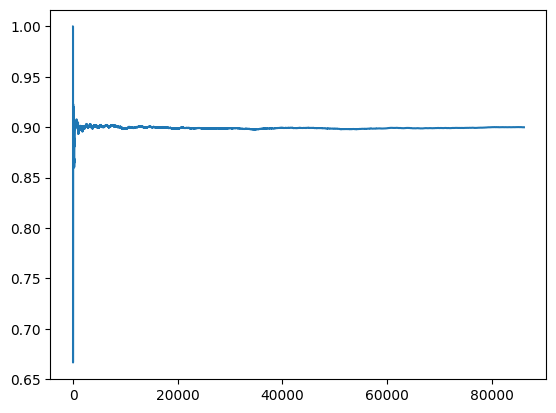

In [28]:
ds_id = "Neelectric/Replay_0.1.OpenR1-Math-220k_extended.wildguardmix.Llama3_4096toks"
ratios = get_ratios(ds_id)
sns.lineplot(ratios)

100%|██████████| 86158/86158 [00:10<00:00, 8380.84it/s] 


<Axes: >

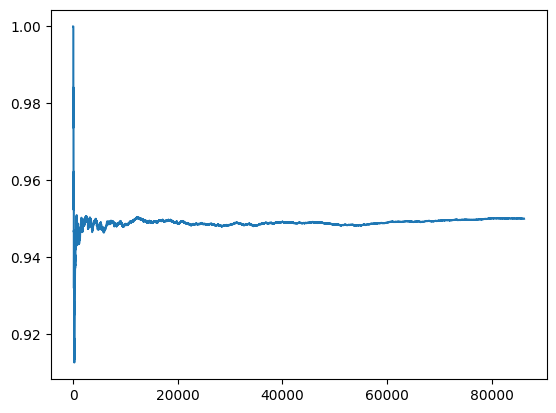

In [30]:
ds_id_05 = "Neelectric/Replay_0.05.OpenR1-Math-220k_extended.wildguardmix.Llama3_4096toks"
ratios_05 = get_ratios(ds_id_05)
sns.lineplot(ratios_05)

In [32]:
print(ratios_05[-1])

0.9500104459249287
